# Working with Raster data in Python

## Learning Objectives

 * read spatial raster formats from web services and files
 * write spatial raster formats to disk
 * apply basic operations on raster data
 * plot spatial raster data with matplotlib and rasterio
 * work with categorical rasters


## Raster data

Raster data is stored as a grid of values which are rendered as pixels on a map. Each pixel value represents an area on the Earth’s surface.
Digital photographs are also a raster. A geospatial raster includes spatial information that connects the data to a particular location on Earth. 

![](./img/raster-concept.png)
Source: Colin Williams, NEON

## All good with Seurasaaris trees?

As researchers we often wonder about the weirdest things. 
In this lesson we will wonder about how the trees of [Seurasaari](https://www.hel.fi/helsinki/en/culture/recreation/in-helsinki/seurasaari) (small island in western Helsinki) were doing in end of summer 2021.

And since we do not just wonder but also want to really know, we will see if we can answer this question using some freely available data and open source tools.

Our data: \
-> Earth Observation (ie satellite remote sensing) data: we want to know the situation at a specific time and place. \
-> multispectral remote sensing data: we are interested in spectral information rather than structural. \
-> [Sentinel-2 data](https://sentinel.esa.int/web/sentinel/missions/sentinel-2): Seurasaari is rather small and Sentinel-2 provides up to 10 meter spatial resolution. It also provides data in 12 bands (wavelengths intervals) and the bottom-of-atmosphere (L2A) product is corrected for atmospheric disturbances, which is directly provided by the European Space Agency (ESA).

Our (main) tool:
[Rasterio](https://rasterio.readthedocs.io/en/latest/intro.html) Python package (depends on [GDAL](https://gdal.org/)). 

And a collection of scripts that will help us along the way: The [Seurasaari toolbox](./seurasaari_toolbox.py).

In [1]:
# Let's import rasterio library (https://rasterio.readthedocs.io/en/latest/)
import rasterio
print(rasterio.__version__)

# and a small toolbox that will help us with the tasks
import seurasaari_toolbox as stb

1.2.10


### Getting the data

There is many tools around to get this data. E.g. [ESAs SciHub](https://scihub.copernicus.eu/dhus/) as graphical web interface. [FORCE](https://force-eo.readthedocs.io/en/latest/) and [sentinelsat](https://sentinelsat.readthedocs.io/en/stable/) are examples of tools that are used from the command line.

Lucky for us, we have a pre-processed geotiff file on Allas ( url: https://a3s.fi/gis-courses/pythongis_2022/S2B_RGBNIR_20210926_Helsinki.tif ) that includes 4 band (rgbnir) Sentinel-2 data of 26.09.2021. You can see the preprocessing steps done to this file in `prepare_data.py`.
Let's get it and have a look..

In [2]:
# Utilize the toolbox to download the data from Allas

s2url = "https://a3s.fi/gis-courses/pythongis_2022/S2B_RGBNIR_20210926_Helsinki.tif"
stb.download_data(s2url)


# open the file with rasterio
s2file = "./data/S2B_RGBNIR_20210926_Helsinki.tif"
s2open = rasterio.open(s2file)


> Note: For data on Allas you could also access the data directly without specifically downloading it using vsicurl (virtual system interface for Curl)
like so: `rasterio.open("/vsicurl/https://a3s.fi/gis-courses/pythongis_2022/S2B_RGBNIR_20210926_Helsinki.tif")`

### What metadata is available?

In [3]:
# Check the files metadata
s2open.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 2466,
 'height': 1832,
 'count': 4,
 'crs': CRS.from_epsg(32635),
 'transform': Affine(10.0, 0.0, 379820.0,
        0.0, -10.0, 6685870.0)}

Affine transformation tells about how the pixels are mapped to a geospatial location with origin, pixel size and rotation of the raster in the geographic coordinate system. 
> Note that bounds, crs and transformation are interrelated and updating one will also affect the others.

The four bands available to us (1:blue, 2:green, 3:red, 4: near infrared) can tell us different things.

![](./img/vegetation_reflectance.png)

Credit: Physicsopenlab, http://physicsopenlab.org/wp-content/uploads/2017/01/veg.gif


### Visualizing the near infrared band

It looks like the near infrared can tell us something about vegetation. Let's visualize it!


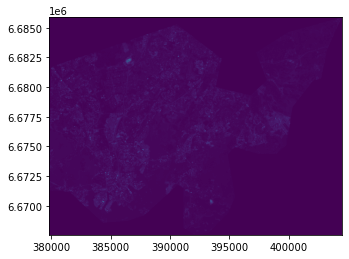

<AxesSubplot:>

In [4]:
# rasterio provides its own plotting functions
from rasterio.plot import show

# with read we can access the different bands
show(s2open,4)

Great, we can see that our data shows Helsinki, and that we have a range of different reflectances in the near infrared band.

### Common false color image

But there is better ways to look at vegetation. Let's for example have a look at a "common false color image" which utilizes the nir, green and red band to be represented as red, green and blue bands for the image.

In [5]:
# Read the raster values into numpy arrays
nir = s2open.read(4)
red = s2open.read(3)
green = s2open.read(2)

# check what we got

print(type(nir))
print(nir.dtype)

<class 'numpy.ndarray'>
uint16


Uint is chosen for Sentinel-2 data to conserve storage space. To get the reflectance, every pixel value needs to be divided by 10000. Sentinel-2 L2A products no-data value is 0. We can set these 0 values to np.nan instead. These are common processes for satellite remote sensing data. However, the correction factore and nodata values might be different for different sensors. You can usually find these from metadata.

In [6]:
#for this we need numpy
import numpy as np

# rescaling bands to values between 0 and 1
red = red / 10000
green = green / 10000
nir = nir / 10000

# replacing 0 with np.nan
red[red == 0] = np.nan
green[green == 0] = np.nan
nir[nir == 0] = np.nan
nir.dtype

dtype('float64')

In [7]:
#use pyplot imshow for plotting 
#in case of multiband images, it interprets the first band as red, second as green and third as blue 
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# we want nir -> red, red -> green and green -> blue
falsecolor_stack = np.dstack((nir, red, green))

# check that it worked
falsecolor_stack.shape

(1832, 2466, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


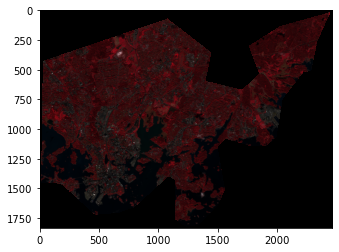

In [9]:
#and plot it using imshow
plt.imshow(falsecolor_stack)

We divided the values by 10000 to get values between 0 and 1. However, imshow warns us that it had to clip some values for the plot. Let's see what went wrong. 

In [10]:
# check out min, max and mean of one band
print(np.nanmin(red), "-", np.nanmax(red), "mean:", np.nanmean(red))

0.0001 - 1.6208 mean: 0.04939044723460403


It seems like we do have some values outside of the [0,1] range. In this case these values are likely some artifacts from preprocessing or atmospheric correction. So we can set all values above 1 to 1.

In [11]:
#use numpy to set all values > 1 to 1
red[red>1] =1
green[green>1] = 1
nir[nir>1] =1

# and stack again
falsecolor_stack = np.dstack((nir, red, green))

print(np.nanmin(red), "-", np.nanmax(red), "mean:", np.nanmean(red))

0.0001 - 1.0 mean: 0.0493795718101385


That looks better.
Let's also look at how our values are distributed with [rasterios histogram plotting function](https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.show_hist) :

In [12]:
#use rasterio show_hist
from rasterio.plot import show_hist

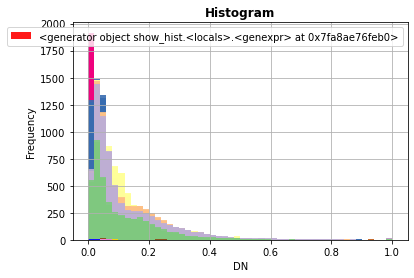

In [13]:
# and plot the histogram

show_hist(falsecolor_stack, bins=50, stacked=False, alpha=0.9,histtype="stepfilled")

**Check your understanding:**

* Something seems off about the histogram, can you find out what and fix it?
([Hint](https://rasterio.readthedocs.io/en/latest/topics/plotting.html): check the shape of stack and how rasterio stores it )

* The basic output of the histogram function is not very nice and even wrong in one place, can you do better?
(Hint: show_hist also takes for example matplotlib axes (`ax=`) as optional parameters)

first fix
(1832, 2466, 3)
(3, 1832, 2466)


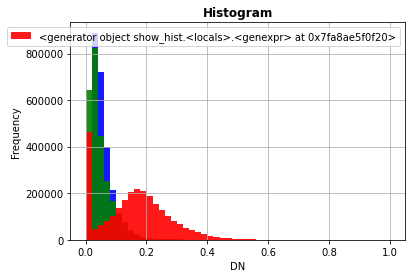

second fix


Text(0.5, 0, 'Reflectance')

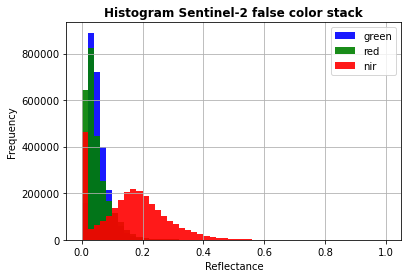

In [14]:
# %load cyu1_solution.txt
# Test your understanding:

# Something seems off about the histogram, can you find out what and fix it? (Hint: check the shape of stack)

# check that we have the data in correct format for show_hist (bands, height, width)

print("first fix")

print(falsecolor_stack.shape)
stack_for_hist = np.transpose(falsecolor_stack,axes=[2,0,1])
print(stack_for_hist.shape)

# and plot the histogram

show_hist(stack_for_hist, bins=50, lw=0, stacked=False, alpha=0.9,histtype="stepfilled")

# The basic output of the histogram function is not very nice and even wrong in one place, can you do better? (Hint: show_hist also takes matplotlib axes (`ax=`) and title `title=` as optional parameters)

# add labels (we know that nir is first, red, is second and green is third band in our stack) using label
# add descriptive title 
# adjust x-axis label by using matplotlibs axis to reflect what is actually shown in our case 

print("second fix")

fig, ax = plt.subplots()
show_hist(stack_for_hist, bins=50, lw=0, stacked=False, alpha=0.9,histtype="stepfilled", label = ["nir","red","green"], title = "Histogram Sentinel-2 false color stack", ax = ax)
ax.set_xlabel("Reflectance")

# in this case the histogram could also be plotted using only matplotlib.pyplot

It looks like we have a lot of values below 0.5, but using the whole 0-1 range to plot the false color image. This may be the reason it appears so dark.
Let's utilize some image processing (from the toolbox) to disregard very large and very small values and stretch the remaining values across the histogram for visualization purposes.

In [15]:

stretchnir = stb.stretch(nir)
stretchred = stb.stretch(red)
stretchgreen = stb.stretch(green)

print("before")
print(np.nanmin(red), "-", np.nanmax(red), "mean:", np.nanmean(red))
print("after")
print(np.nanmin(stretchred), "-", np.nanmax(stretchred), "mean:", np.nanmean(stretchred))

before
0.0001 - 1.0 mean: 0.0493795718101385
after
0.0 - 1.0 mean: 0.2560808133604525


That looks better, let's plot it!

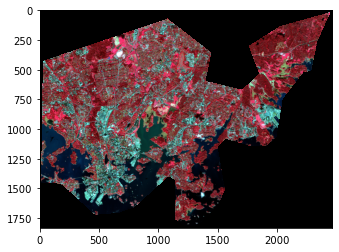

In [16]:
#stack and plot histogram stretched image

stretchstack = np.dstack((stretchnir, stretchred, stretchgreen))

plt.imshow(stretchstack)

Much better. Now we can see how green Helsinki is.

### Cropping the image

However, cannot see really well what is going on on Seurasaari.

Since we are not interested in the rest of Helsinki, let's crop out Seurasaari:

In [17]:
#use osmnx tool for getting a geodataframe with a polygon representing Seurasaari

import osmnx as ox

# Keywords for Seurasaari in such format that they can be found from OSM: https://nominatim.openstreetmap.org/ui/search.html
seurasaari_string = "Seurasaari, Helsinki, Finland"

# Retrieve the geometries of those areas using osmnx and store them in a geodataframe
seurasaari_df = ox.geocode_to_gdf(seurasaari_string)


/home/samwitt/miniconda3/envs/autogis-environment/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


For the cropping operation we need both the Sentinel-2 data and the Seurasaari polygon in the same Coordinate Reference System (crs):

In [18]:
#check seurasaaris crs
seurasaari_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
# reproject polygon to raster crs
seurasaari_df = seurasaari_df.to_crs(crs=s2open.crs)

seurasaari_df.crs

<Derived Projected CRS: EPSG:32635>
Name: WGS 84 / UTM zone 35N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 35N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now we need to get the format of the seurasaari polygon into something usable for rasterio (https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask).


In [20]:
#let's use our toolbox to get the features  
seurasaari_coords = stb.getFeatures(seurasaari_df)
seurasaari_coords

[{'type': 'Polygon',
  'coordinates': [[[382344.9971561417, 6673616.888177212],
    [382354.17072542664, 6673590.915943632],
    [382370.7947931855, 6673576.2057031905],
    [382373.0829994244, 6673572.78877031],
    [382373.6379052509, 6673567.254306869],
    [382371.5774497742, 6673561.692424062],
    [382368.7605197756, 6673555.218691007],
    [382363.1698960569, 6673550.1825911775],
    [382360.9895701044, 6673544.000460709],
    [382357.4774862489, 6673538.696977576],
    [382355.1685323106, 6673531.794576373],
    [382351.6784313597, 6673527.003048768],
    [382351.524597344, 6673522.215762683],
    [382351.3167443606, 6673512.637983154],
    [382352.2202723919, 6673504.997106341],
    [382346.5148927006, 6673502.784329697],
    [382343.2367288743, 6673498.197747812],
    [382345.187057986, 6673493.420856412],
    [382352.77284785797, 6673492.998777486],
    [382356.63237601274, 6673492.874760614],
    [382358.50383560726, 6673489.270606826],
    [382372.888402302, 6673482.244198

In [21]:
# use the mask function to crop the Sentinel-2 image
import rasterio.mask

seurasaariS2_array, seurasaariS2_transform = rasterio.mask.mask(dataset=s2open, shapes=seurasaari_coords, crop=True)

# check the shape
seurasaariS2_array.shape


(4, 118, 68)

Let's store this cropped version as geotiff.

In [22]:
# Copy the metadata from the original geotiff
seurasaariS2_meta = s2open.meta.copy()

seurasaariS2_meta.update({"height": seurasaariS2_array.shape[1],
                 "width": seurasaariS2_array.shape[2],
                 "transform": seurasaariS2_transform }
                )

#metadata as keyword arguments (key-value pairs)

seurasaariS2_file = "./data/S2B_RGBNIR_20210926_Seurasaari.tif"

# write the file as geotif
with rasterio.open(seurasaariS2_file, "w", **seurasaariS2_meta) as dest:
        dest.write(seurasaariS2_array)

Now we are done with the Sentinel-2 data of Helsinki. So let's not forget to close it.

In [23]:
s2open.close()

And we can open the cropped rasterfile again with rasterio and visualize the nir band. 

4


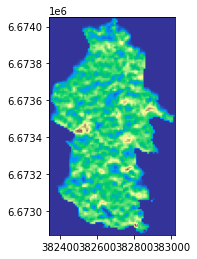

<AxesSubplot:>

In [24]:
# Open the cropped raster file
seurasaariS2 = rasterio.open(seurasaariS2_file)

print(seurasaariS2.count)

# Visualize with colormap defined
show((seurasaariS2, 4), cmap="terrain")

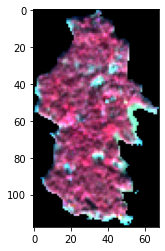

In [25]:

# use the toolbox to prepare the image (as we did for Helsinki)
ss_falsecolorstack = stb.make_false_color_stack(seurasaariS2)

# and plot it
plt.imshow(ss_falsecolorstack)


Looks like there are a lot of trees on Seurasaari with high reflectances in the near infrared.



### Vegetatiom health indicator

The false color image does give us an impression about the vegetation on Seurasaari, but there is also other ways to look at "vegetation greenness/health".

One often used indicator for vegetation health is the [Normalized Difference Vegetation Index, NDVI](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/) 

![](./img/ndvi.jpg)

Credit: Robert Simmon, NASA, https://www.nasa.gov/topics/earth/features/obscure_data.html

It is calculated as:

$$NDVI = \frac{nir-red}{nir+red}$$

This formula is applied to every single pixel in the raster. So we will need to do some band math / map algebra. And since we can read our data into numpy arrays, let's utilize that and read the nir and red band into arrays:



In [26]:
#open the Seurasaari geotif 
seurasaariS2 = rasterio.open(seurasaariS2_file)

# make use of the read_band function of the toolbox to read and prepare the arrays
# red is our channel number 3
ss_red = stb.read_band(seurasaariS2,3)
# nir is our channel number 4
ss_nir = stb.read_band(seurasaariS2,4)

# check arrays datatype; range of NDVI is [0,1] -> float
ss_red.dtype

dtype('float64')

In [27]:

# since the divisor can be 0, we choose to ignore that error from numpy
np.seterr(divide="ignore", invalid="ignore")


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Then we can calculate the NDVI value for every single pixle in our Seurasaari raster:

In [28]:
#use the formula to calculate NDVI
ndvi = (ss_nir - ss_red) / (ss_nir + ss_red)

# check what is the minimum NDVI value in our raster
np.nanmin(ndvi)
ndvi.dtype

dtype('float64')

Let's also visualize the NDVI using imshow (currently ndvi is only an array without geoinformation):

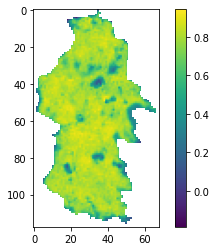

In [29]:
# Plot the NDVI
plt.imshow(ndvi, cmap="viridis")
# Add colorbar to show the index
plt.colorbar()

Looks like the Seurasaari has been green and healthy. Let's store this ndvi array with added geoinformation as geotif:

In [30]:
#copy metadata from original 
ndvi_meta = seurasaariS2.meta.copy()

#we now only have one band instead of four, and the datatype changed, everything else stays same
ndvi_meta.update({"count" : 1,
                 "dtype" : np.dtype("f8")})

ndvi_file = "./data/S2_NDVI_Seurasaari.tif"

#write the NDVI array to geotif
with rasterio.open(ndvi_file, "w", **ndvi_meta) as dest:
    dest.write_band(1, ndvi.astype(np.dtype("f8")))


**Check your understanding:**

* In above plot we do not have Coordinates at the plot, why? How could we get them?

<class 'numpy.ndarray'>


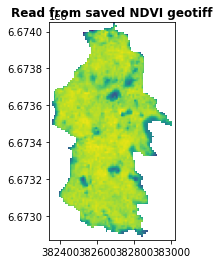

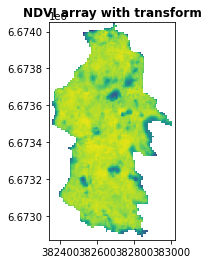

<AxesSubplot:title={'center':'NDVI array with transform'}>

In [31]:
# %load cyu2_solution.txt
#Test your understanding:

#* In above plot we do not have Coordinates at the plot, why? 

print(type(ndvi))

# -> array, does not have any coordinates attached

# How could we get them?

# -> plot the newly saved file

with rasterio.open("./data/S2_NDVI_Seurasaari.tif") as src:
    show(src, title="Read from saved NDVI geotiff")

# We could also pass the transform with the array to 'show'

show(ndvi, transform=seurasaariS2.transform, title="NDVI array with transform")

### Collecting more information

In general, it looks like the vegetation on Seurasaari is doing well. But what are those darker areas?

It is possible that not everything is trees on Seurasaari.

Let's check what else there is...

There is many possibilities to do that, we are going to look at the land cover classification [Corine](https://land.copernicus.eu/pan-european/corine-land-cover) , wich SYKE kindly provides for Finland: https://ckan.ymparisto.fi/dataset/%7B0B4B2FAC-ADF1-43A1-A829-70F02BF0C0E5%7D with the categories provided as excel sheet: https://geoportal.ymparisto.fi/meta/julkinen/dokumentit/CorineMaanpeite2018Luokat.xls

For this lesson we will use a cropped versio of the file provided by SYKE, covering Seurasaari.

First, lets visualize Corine data of Seurasaari:

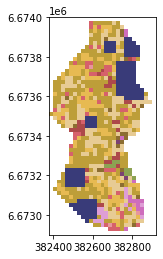

In [32]:
corine_file = "./data/Clc2018_Seurasaari.tif"


with rasterio.open(corine_file) as corine:
    show(corine,1, cmap = "tab20b")

Up to now we have been working with continuous rasterdata representing reflectance between 0 and 1.
Corine is an example of a categorical raster, with each value representing a land cover class.
From the plot above we can see, that we have multiple different land cover classes on Seurasaari.

Let's see what land cover classes we have on Seurasaari using `zonal_stats` function from [rasterstats](https://pythonhosted.org/rasterstats/).
Note that in this case we could also use numpy to collect values present in the corine array. However, if we had not cropped the original Sentinel-2 file, then we would get the classes of whole Helsinki, in which case using `zonal_stats` makes more sense.

In [33]:
from rasterstats import zonal_stats

# note that zonal stats takes filenames as well as certain opened file formats
zstats = zonal_stats(seurasaari_df, corine_file, categorical=True)
zstats

[{2: 12,
  3: 89,
  4: 42,
  14: 10,
  23: 20,
  25: 303,
  27: 140,
  28: 137,
  30: 38,
  33: 1,
  34: 31,
  36: 51,
  39: 3,
  41: 3,
  45: 7,
  46: 4,
  48: 15,
  49: 2}]

For categorical rasters, `zonal_stats` output is a dictionary with categoryvalue (= land cover class) and number of pixels belonging to that class.
Now it would be great to know what these category values mean to find out what is forest. 
Luckily class descriptions are provided as excel file, of which we can pack the interesting (english and detailed) description into a dictionary:

We can add this directly to zonal stats to get the output human reader friendly with classnames instead of class values (https://pythonhosted.org/rasterstats/manual.html#working-with-categorical-rasters):

In [34]:
#use toolbox function to get a dictionary of land cover class value and its name as category map
cat_dict = stb.get_corine_dict("https://geoportal.ymparisto.fi/meta/julkinen/dokumentit/CorineMaanpeite2018Luokat.xls")
zstats = zonal_stats(seurasaari_df,corine_file, categorical=True, category_map=cat_dict, stats=["count"])


And we can get the pecentage of pixels for each class, by utilizing the 'count' statistics, which counts all valid pixels within the polygon. 

In [35]:
# use function from toolbox to calculate percentages for each class
stb.get_zonal_stats_percentage(zstats)

{'Discontinuous urban fabric': 1,
 'Commercial units': 10,
 'Industrial units': 5,
 'Sport and leisure areas': 1,
 'Broad-leaved forest on mineral soil': 2,
 'Coniferous forest on mineral soil': 33,
 'Coniferous forest on rocky soil': 15,
 'Mixed forest on mineral soil': 15,
 'Mixed forest on rocky soil': 4,
 'Transitional woodland/shrub  cc <10%  ': 0,
 'Transitional woodland/shrub, cc 10-30%,on mineral soil': 3,
 'Transitional woodland/shrub, cc 10-30%,  on rocky soil': 6,
 'Bare rock': 0,
 'Inland marshes, terrestrial': 0,
 'Salt marshes, terrestrial': 1,
 'Salt marshes, aquatic': 0,
 'Water bodies': 2,
 'Sea and ocean': 0}

Now we know that there are commercial and industrial units on Seurasaari. Note that the Corine file was clipped approximately at the coast, which explains that there is 0.x% of sea and ocean and bare rock, even though if you have ever been to Seurasaari we know it is there.

But we are only interested in trees (forest in Corine case), so lets filter out only forest classes: 'Broad-leaved forest on mineral soil', 'Coniferous forest on mineral soil', 'Coniferous forest on rocky soil', 'Mixed forest on mineral soil', 'Mixed forest on rocky soil'. Let's get the codes of these classes.

In [36]:
forestcodes = stb.get_forest_codes()

Let's create a mask which shows us where there is forest, and no forest on Seurasaari. 
First we have to read the Corinefile into a numpy array:

In [37]:
# read the first and only band of the Corine dataset
with rasterio.open(corine_file) as corine:
    corine_array = corine.read(1)
    
corine_array

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

Now we mask the corinearray everywhere where the values are equal to any of the forest codes:

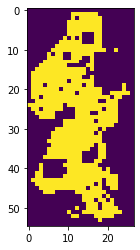

<AxesSubplot:>

In [38]:
forestmask = stb.create_forest_mask(corine_array, forestcodes)

show(forestmask,1)

Now we store the resulting mask as a shapefile using [fiona](https://fiona.readthedocs.io/en/latest/manual.html) (a Python package for reading/writing geographic data files; geopandas would be another option) and [resterio.features](https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html):

In [39]:
# import fiona and rasterio features
import fiona
from rasterio import features


# use features to get the values and connected regions in the mask and store them as polygons with the corresponding raster value as field.
results = ({"properties": {"raster_val": v}, "geometry": s} for i, (s, v) in enumerate(features.shapes(forestmask, transform = corine.transform)))

forestmask_file = "./data/forestmask_corine_seurasaari2.shp"
# use fiona to store the polygons as shapefile with metadata from the corine raster
with fiona.open(forestmask_file, "w", driver="Shapefile", crs=corine.crs, schema={"properties": [("raster_val", "int")], "geometry": "Polygon"}) as dst:
    dst.writerecords(results)

We are only interested in the NDVI values of forests, so we can use the created shapefile to mask out non-forest areas in the NDVI raster. and we can get one value to indicate "how healthy the trees on Seurasaari were in end of September 2021":

In [40]:

#open the Seurasaari NDVI file and use rasterio mask to mask out areas that are not forest
with rasterio.open(ndvi_file) as ndvi:
    shapefilename = stb.get_reprojected_shapefilename(ndvi.crs, "./data/forestmask_corine_seurasaari2.shp")
    
    # we only want to regard polygons that have the value 1 (forest) that we can get from the raster_val field
    with fiona.open(shapefilename, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile if feature["properties"]["raster_val"] == 1]
    
    #use rasterio.mask again
    ndvi_forest, ndvi_forest_transform = rasterio.mask.mask(ndvi, shapes, crop=True, nodata=np.nan)

print("Mean NDVI value of Seurasaari forests in September 2021:")
print(np.nanmean(ndvi_forest))

Mean NDVI value of Seurasaari forests in September 2021:
0.7991306676737671


/home/samwitt/miniconda3/envs/autogis-environment/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Seems like the trees on Seurasaari are green and probably rather healthy :)

## Keypoints

* you can do almost anything to geospatial rasters with rasterio
* single bands can be read into numpy arrays and handled as such for e.g band maths
* be aware when you are working with geocoded data and when you are working with arrays
* you can use rasterio mask to crop a rasterfile with a shapefile
* rasterstats.zonal_statistics is helpful when you want to summarize pixel values from categorical and continuous rasters within polygons

## References

Inspiration for this lesson was drawn from below sources which are also good resources for further reading:

    * Original Raster lesson of this course: https://autogis-site.readthedocs.io/en/latest/lessons/Raster/overview.html (check especially Mosaicing)
    * Raster data in Python intros: 
        * https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/
        * https://carpentries-incubator.github.io/geospatial-python/05-raster-structure/
        * https://geohackweek.github.io/raster/04-workingwithrasters/
        * https://kodu.ut.ee/~kmoch/geopython2019/L4/raster.html (check out especially the part about reprojecting a raster)
        * https://geoscripting-wur.github.io/PythonRaster/
        * https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html
        * https://geobgu.xyz/py/rasterio.html
        * https://snowex-hackweek.github.io/website/tutorials/geospatial/raster.html
        * https://carpentries-incubator.github.io/geospatial-python/01-intro-raster-data/index.html
    * sample raster values at specific coordinates: https://hackernoon.com/sampling-raster-values-at-specific-coordinates-with-python
    * Virtual Rasters: https://docs.csc.fi/support/tutorials/gis/virtual-rasters/
    * Great collection of Geospatial Python resources: https://github.com/giswqs/python-geospatial